# Canadian Rental Prices Regression

## 1. Introduction

We're going to work with the data preprocessed in [this notebook](DataPreprocessing.ipynb), which contains rental price data associated with multiple factors like the location, type of rental, number of rooms, etc. 

The price is our target variable. We're going to explore different regularized regression models before choosing a final model that we will use to predict new rental prices.

In [178]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse

In [65]:
# Load data
with open('../Data/preprocessed_data.pkl', 'rb') as handle:
    data = pickle.load(handle)

city_frequency_map = data['city_frequency_map']
df = data['df']

df.shape

(19045, 11)

### Create helper functions

In [67]:
def residual_analysis_plots(model):
    '''Plots the residuals and the Q-Q Plot in the same figure'''
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15, 6))
    
    sns.scatterplot(x=model.predict(), y=model.resid, ax=ax1)
    ax1.set_title("Residual Plot")
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Residuals")
    ax1.axhline(0, linestyle="--", color="orange")

    ax2.hist(model.resid, bins=30)
    ax2.set_title("Distribution of the residuals")
    
    stats.probplot(model.resid, dist="norm", plot=ax3)
    ax3.set_title("Normal Q-Q Plot")  

    plt.show()

In [223]:
def eval_performance(test, predictions):
    MAE = mean_absolute_error(test, predictions)
    MSE = mean_squared_error(test, predictions)
    RMSE = rmse(test, predictions)
    test_mean = test.mean()
    pred_mean = predictions.mean()
    
    metrics = {
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        #'R-squared': r2_score(test, predictions),
        #'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)
    
    return df

## 2. Initial regression model

In [70]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [71]:
# Fit model
X_constant = sm.add_constant(X)
model = sm.OLS(y, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     944.6
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:17:56   Log-Likelihood:            -1.5366e+05
No. Observations:               19045   AIC:                         3.073e+05
Df Residuals:                   19034   BIC:                         3.074e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                471.1440     27.976     16.841      0.000     416.308     525.980
city                   0.0546      0.004     15.212      0.000       0.048       0.062
beds                 172.6340      8.248     20.930      0.000     156.467     188.801
baths                474.3647     12.722     37.286      0.000     449.428     499.302
sq_feet                0.2904      0.015     19.359      0.000       0.261       0.320
cats                 -82.9094     22.826     -3.632      0.000    -127.650     -38.169
dogs                 214.5386     22.055      9.727      0.000     171.308     257.769
type_Apartment       417.3271     17.785     23.465      0.000     382.467     452.187
type_Basement       -188.9132     28.613     -6.602      0.000    -244.998    -132.829
type_House            87.9649     29.597      2.972      0.003      29.951     145.979
type_Room For Rent -1237.6363     41.149    -30.077      0.000   -1318.292   -1156.980
==============================================================================
Omnibus:                    22309.992   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13456618.733
Skew:                           5.547   Prob(JB):                         0.00
Kurtosis:                     132.748   Cond. No.                     2.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

The R-squared is 0.332, which indicates that 33.2% of the variance of the price is explained by the model, which suggests a poor fit.

Based on the p-values, all features seem to be statistically significant.

The Durbin-Watson score of 0.911 indicates that the errors are not independent.

In [73]:
# Evaluate performance
y_pred = model.predict(X_constant)
eval_performance(y, y_pred)

,Metric,Value
0,MAE,503.9871
1,MSE,596449.3354
2,RMSE,772.3013
3,Predictions Mean,2145.7767


**Observations**

Compared to the mean value, the MAE and RMSE are pretty high, which indicates our model doesn't perform really well.

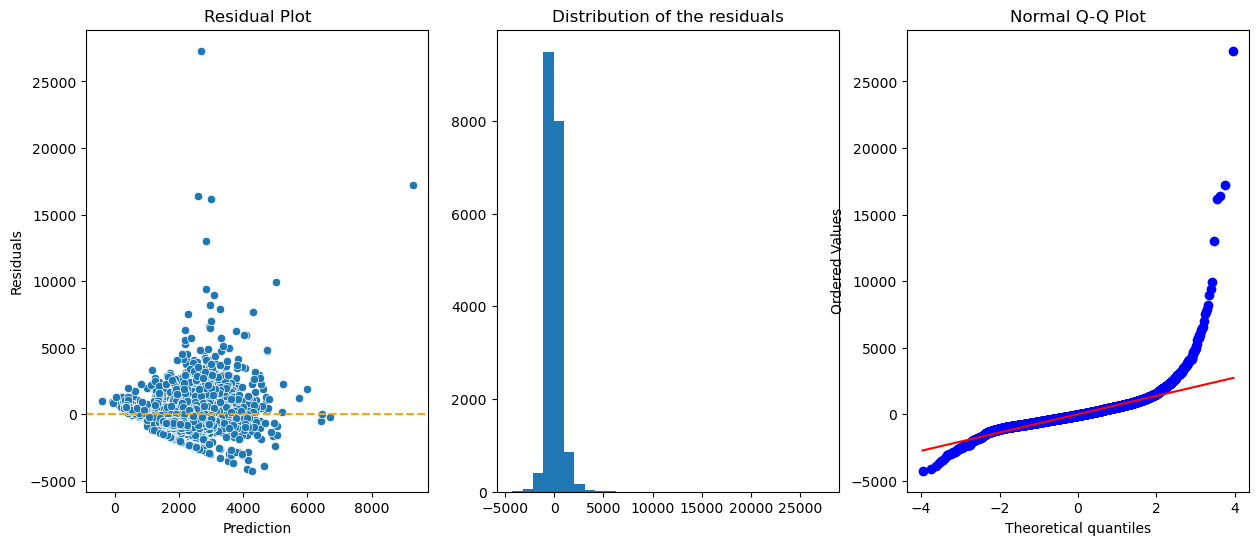

In [75]:
# Plot residuals
residual_analysis_plots(model)

**Observations**

The residuals do not seem to be independent and normally distributed. Looking at the Q-Q Plot, we can also see that there are a lot of outliers.

## 3. Second regression model

In [78]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,city,beds,baths,sq_feet,cats,dogs,type_Apartment,type_Basement,type_House,type_Room For Rent
0,-1.077503,0.316719,1.782130,0.936298,0.685547,0.731366,-1.526285,-0.237513,-0.238989,-0.148329
1,-1.077503,1.347463,1.782130,1.127223,0.685547,0.731366,-1.526285,-0.237513,-0.238989,-0.148329
2,-1.077503,0.316719,1.782130,0.478488,0.685547,0.731366,-1.526285,-0.237513,-0.238989,-0.148329
3,-1.077503,0.316719,1.782130,0.936298,0.685547,0.731366,-1.526285,-0.237513,-0.238989,-0.148329
4,-1.077503,0.316719,1.782130,0.829544,0.685547,0.731366,-1.526285,-0.237513,-0.238989,-0.148329
...,...,...,...,...,...,...,...,...,...,...
19040,-1.125095,-1.744768,-0.592395,-1.122819,0.685547,0.731366,0.655186,-0.237513,-0.238989,-0.148329
19041,-1.125095,1.347463,-0.592395,-0.281106,0.685547,0.731366,0.655186,-0.237513,-0.238989,-0.148329
19042,-1.125095,-0.714025,-0.592395,-0.876464,0.685547,0.731366,0.655186,-0.237513,-0.238989,-0.148329
19043,-1.125095,-1.744768,-0.592395,-1.122819,0.685547,0.731366,0.655186,-0.237513,-0.238989,-0.148329


In [88]:
# Fit the model
X_constant = sm.add_constant(X_scaled)
model = sm.OLS(y, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     944.6
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:18:12   Log-Likelihood:            -1.5366e+05
No. Observations:               19045   AIC:                         3.073e+05
Df Residuals:                   19034   BIC:                         3.074e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2145.7767      5.598    383.321      0.000    2134.804    2156.749
city                  97.5966      6.416     15.212      0.000      85.021     110.172
beds                 167.4849      8.002     20.930      0.000     151.800     183.170
baths                299.6588      8.037     37.286      0.000     283.906     315.412
sq_feet              141.4580      7.307     19.359      0.000     127.135     155.781
cats                 -38.6662     10.645     -3.632      0.000     -59.532     -17.801
dogs                 102.2260     10.509      9.727      0.000      81.627     122.825
type_Apartment       191.3054      8.153     23.465      0.000     175.325     207.285
type_Basement        -42.4733      6.433     -6.602      0.000     -55.083     -29.864
type_House            19.8868      6.691      2.972      0.003       6.771      33.002
type_Room For Rent  -179.6258      5.972    -30.077      0.000    -191.332    -167.920
==============================================================================
Omnibus:                    22309.992   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13456618.733
Skew:                           5.547   Prob(JB):                         0.00
Kurtosis:                     132.748   Cond. No.                         4.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Evaluate performance
y_pred = model.predict(X_constant)
eval_performance(y, y_pred)

,Metric,Value
0,MAE,503.9871
1,MSE,596449.3354
2,RMSE,772.3013
3,Predictions Mean,2145.7767


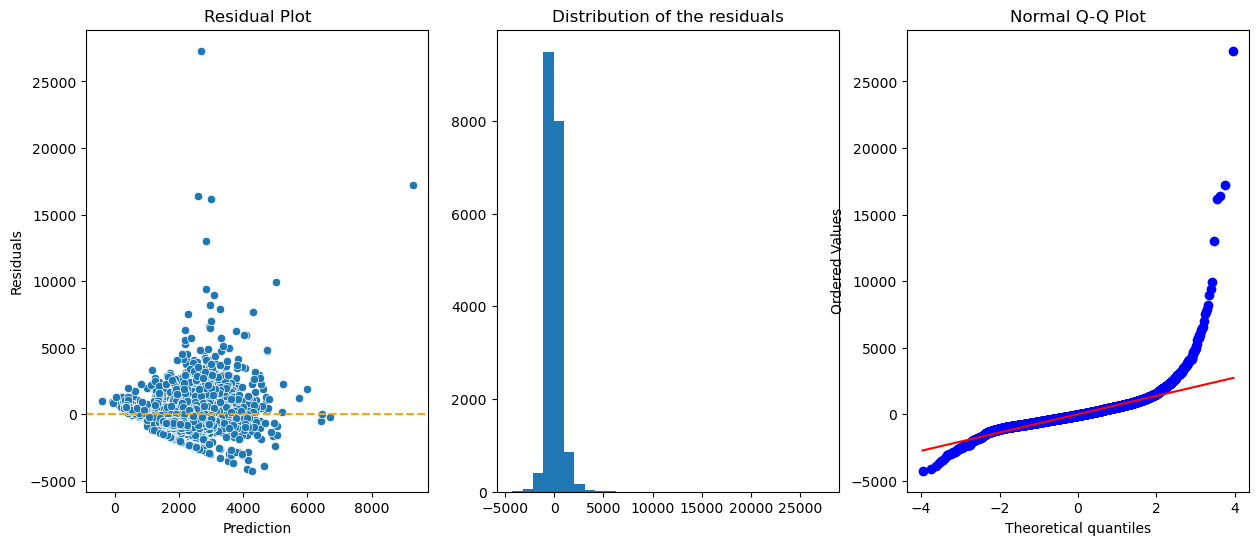

In [23]:
# Plot the residuals
residual_analysis_plots(model)

**Observations**

Scaling the data didn't improve the performance of the model.

## 4. Third regression model

There seems to be non-linear relationships between variables. Let's see if we can obtain better performance with a different polynomial degree.

In [43]:
# Find the optimal degree

train_rmse_errors = []
test_rmse_errors = []
degrees = []

for d in range(1, 5):
    polynomial_converter = PolynomialFeatures(degree=d, include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.15, random_state=1)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))
    
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)
    degrees.append(d)

In [46]:
# Print results

results_df = pd.DataFrame({
    'Degree': degrees,
    'Train RMSE': train_rmse_errors,
    'Test RMSE': test_rmse_errors
})

results_df

,Degree,Train RMSE,Test RMSE
0,1,782.860306,710.004293
1,2,740.979880,676.397104
2,3,709.840241,694.278098
3,4,675.814191,850.470992


The best degree is 2. The RMSE starts to increase at 3.

In [211]:
# Create poly features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

In [213]:
# Fit model
X_constant = sm.add_constant(X_poly)
model = sm.OLS(y, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     240.1
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:26:08   Log-Likelihood:            -1.5262e+05
No. Observations:               19045   AIC:                         3.053e+05
Df Residuals:                   18991   BIC:                         3.058e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              1567.2326     80.742     19.410      0.000    1408.971    1725.494
city                                  0.1311      0.019      6.746      0.000       0.093       0.169
beds                                323.0960     38.061      8.489      0.000     248.492     397.700
baths                               185.2911     58.662      3.159      0.002      70.308     300.274
sq_feet                              -0.5780      0.053    -10.919      0.000      -0.682      -0.474
cats                               -386.6453     51.086     -7.569      0.000    -486.777    -286.513
dogs                               -119.3396     57.135     -2.089      0.037    -231.328      -7.351
type_Apartment                     -285.3663     32.436     -8.798      0.000    -348.944    -221.789
type_Basement                       -94.8266     79.679     -1.190      0.234    -251.004      61.350
type_House                          -97.5038     61.293     -1.591      0.112    -217.643      22.635
type_Room For Rent                  -47.0495     81.124     -0.580      0.562    -206.059     111.960
city^2                            -2.761e-05   2.42e-06    -11.414      0.000   -3.23e-05   -2.29e-05
city beds                            -0.0105      0.005     -1.945      0.052      -0.021    8.11e-05
city baths                            0.0091      0.008      1.190      0.234      -0.006       0.024
city sq_feet                       4.607e-05   9.43e-06      4.884      0.000    2.76e-05    6.46e-05
city cats                             0.0134      0.014      0.962      0.336      -0.014       0.041
city dogs                             0.0199      0.014      1.451      0.147      -0.007       0.047
city type_Apartment                  -0.0213      0.010     -2.203      0.028      -0.040      -0.002
city type_Basement                   -0.0608      0.016     -3.837      0.000      -0.092      -0.030
city type_House                      -0.0043      0.016     -0.272      0.785      -0.035       0.027
city type_Room For Rent              -0.0519      0.027     -1.902      0.057      -0.105       0.002
beds^2                              -59.1926      6.509     -9.094      0.000     -71.950     -46.435
beds baths                          -15.5005     14.210     -1.091      0.275     -43.354      12.353
beds sq_feet                          0.0957      0.016      5.815      0.000       0.063       0.128
beds cats                           -37.5823     32.696     -1.149      0.250    -101.670      26.505
beds dogs                            36.1957     31.556      1.147      0.251     -25.658      98.049
beds type_Apartment                  19.9195     24.377      0.817      0.414     -27.861      67.700
beds type_Basement     

**Observations**

The R-squared has improved from 0.332 to 0.401.

Based on the p-values, some features can be removed with an confidence interval of 95%.

The Durbin-Watson score of 0.963 indicates that the errors are not independent.

In [221]:
# Evaluate performance
y_pred = model.predict(X_constant)
eval_performance(y, y_pred)

,Metric,Value
0,MAE,479.3954
1,MSE,534409.2463
2,RMSE,731.0330
3,R-squared,0.4012
4,Predictions Mean,2145.7767


The performance of the model has not really improved.

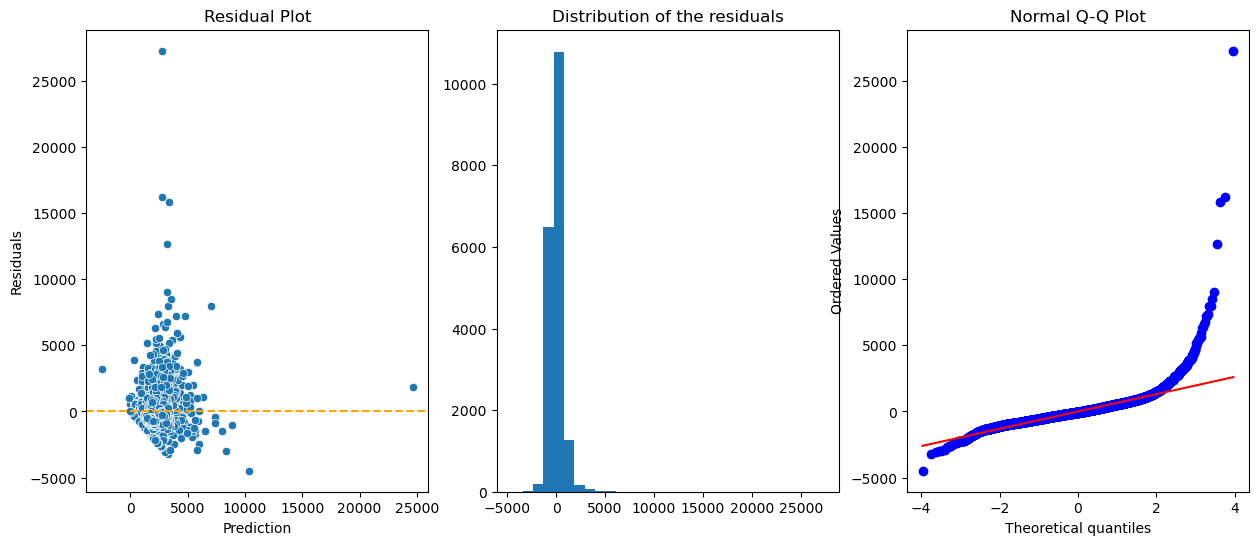

In [226]:
# Plot residuals
residual_analysis_plots(model)

The residuals don't seem to be independant and normally distributed. There are still a lot of outliers if we look at the Q-Q Plot.S

In [ ]:
# TODO: refit model with removed features

In [ ]:
# TODO: assess multicollinearity

In [228]:
# TODO: outliers and influence

## End